## Dependencies

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.6.0.163-1+cuda11.8
!pip uninstall -y tensorflow estimator keras
!pip install -U tensorflow_text tensorflow tensorflow_datasets
!pip install einops
!pip install -U kaleido

## Imports

In [2]:
import concurrent.futures
import random
import platform
import os
import urllib.request
from typing import List, Tuple, Dict, Union, Any, Callable, Optional

import einops
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import numpy as np
import pandas as pd
from PIL import Image
import IPython.display as display
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
print('Tensorflow version:', tf.__version__)
print('Python version:', platform.python_version())

Tensorflow version: 2.13.0
Python version: 3.10.12


## Download Data

In [7]:
path = 'data'

tf.keras.utils.get_file(
    origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
    cache_dir='.',
    cache_subdir=path,
    extract=True
  )
tf.keras.utils.get_file(
    origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
    cache_dir='.',
    cache_subdir=path,
    extract=True
  )

2340801/2340801 [==============================] - 0s 0us/step


'./data/Flickr8k_text.zip'

## Image Data EDA

For the images, we will sample random sets images (e.g. 20) and plot the histrograms:

In [ ]:
def load_random_images(directory: str, num_samples: int, image_size: Tuple[int, int, int]) -> List[tf.Tensor]:
    """
    This function loads in random images from a directory and resizes them. It returns a list of eager tensors.

    Parameters
    ----------
    directory: str
        The directory containing the images.
    num_samples: int
        The number of random images to select.
    image_size: Tuple[int, int, int]
        The input size of the image that the pretrained model expects, to which we have to resize the original image.

    Returns
    -------
    List[tf.Tensor]
        The returned object is a list of eager tensors.
    """
    def load_image(image_path: str, image_size: Tuple[int, int, int]) -> tf.Tensor:
      img = tf.io.read_file(image_path)
      img = tf.io.decode_jpeg(img, channels=3)
      img = tf.image.resize(img, image_size[:-1])
      return img

    all_images = os.listdir(directory)
    sampled_images = random.sample(all_images, num_samples)

    return [load_image(os.path.join(directory, img), image_size) for img in sampled_images]


def plot_histogram_grid(images: List[tf.Tensor], num_samples: int, num_bins: int = 50, sample_fraction: float = 0.1, range: Tuple[int, int] = (0, 255)):
    """
    Plot a grid of histograms for the given images.

    Parameters
    ----------
    images : List[tf.Tensor]
        List of eager tensors representing the images to plot.
    num_samples : int
        Number of images.
    num_bins : int, optional
        Number of bins to use in the histogram, by default 50.
    sample_fraction : float, optional
        Fraction of pixels to sample for the histogram, by default 0.1.
    range : Tuple[int, int], optional
        Range of the images, by default (0, 255).
    """
    num_rows = num_samples // 10 if num_samples % 10 == 0 else num_samples // 10 + 1
    fig, axs = plt.subplots(num_rows, 10, figsize=(20, 2*num_rows))

    axs = axs.flatten()  # Flatten the array of axes to handle the 1-D case

    for i, img in enumerate(images):
        # Flatten the image and convert to numpy array
        img_flat = tf.reshape(img, [-1]).numpy()

        # Sample the pixels
        num_pixels = len(img_flat)
        num_samples = int(sample_fraction * num_pixels)
        pixel_samples = np.random.choice(img_flat, size=num_samples, replace=False)

        # Plot the histogram
        axs[i].hist(pixel_samples, bins=num_bins, color='black', alpha=0.6, range=range)

    plt.title('Histogram of Image Pixels')
    plt.tight_layout()
    plt.show()

Plot the histograms:

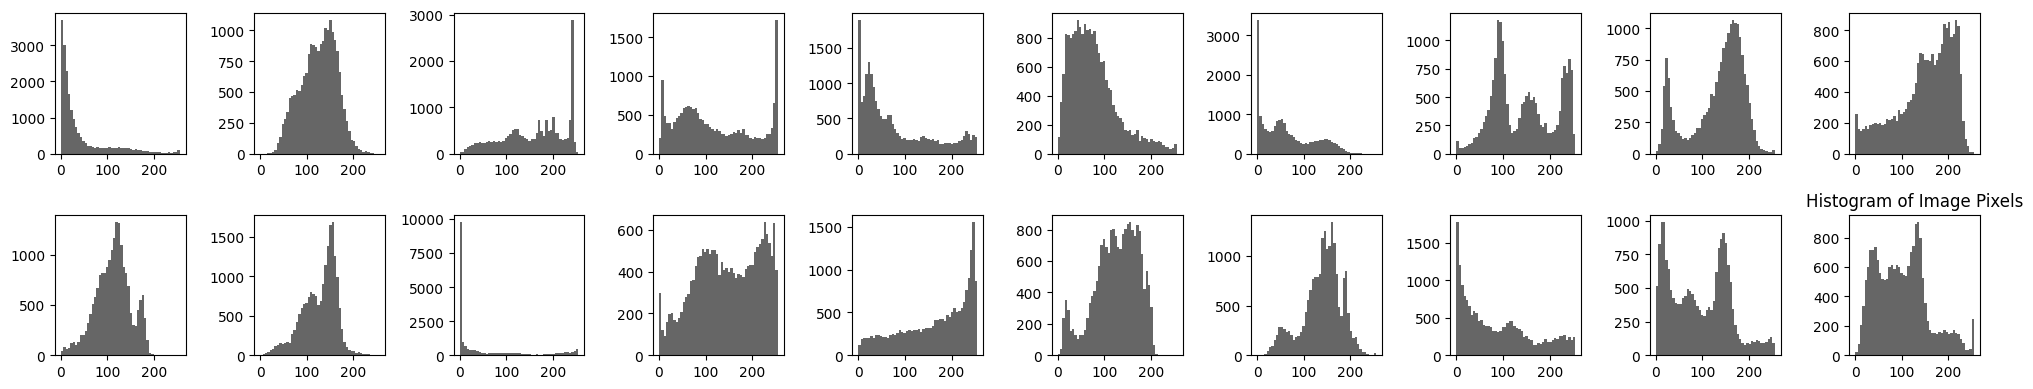

In [ ]:
num_samples = 20
image_size = (256, 256, 3)

images = load_random_images('/content/data/Flicker8k_Dataset', num_samples, image_size)

plot_histogram_grid(images, num_samples)

### Scaling

We can scale the pixel values for all images to `[0, 1]` and the plot the new histograms:

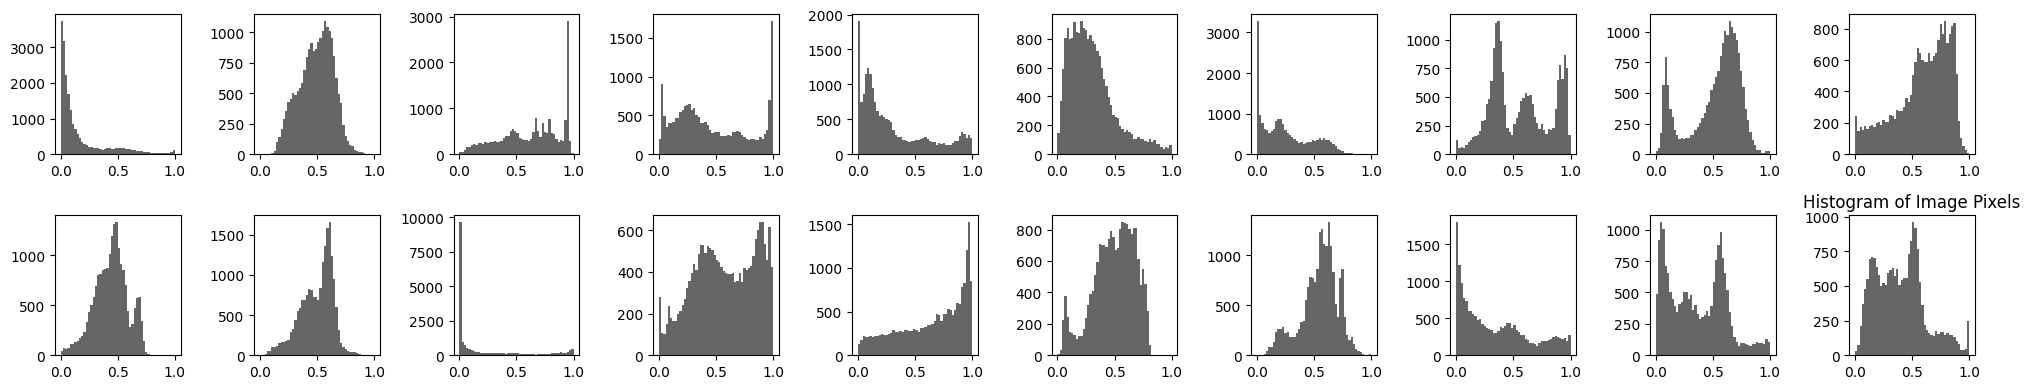

In [ ]:
scaled_images = [(image / 255.) for image in images]

plot_histogram_grid(scaled_images, num_samples, range=(0, 1))

### Standardize

In [ ]:
def standardize_image(image: tf.Tensor) -> tf.Tensor:
    """
    Standardize an image by scaling pixel values to have zero mean and unit variance.

    Parameters
    ----------
    image : tf.Tensor
        A TensorFlow tensor representing an image. The tensor shape should be (height, width, channels).

    Returns
    -------
    tf.Tensor
        A TensorFlow tensor representing the standardized image. The tensor shape is the same as the input.
    """
    # Calculate the mean and standard deviation of the pixel values (global normalization or channel-wise)
    mean, std = tf.nn.moments(image, axes=[0, 1])

    # Subtract the mean and divide by the standard deviation to standardize the pixel values
    standardized_image = tf.map_fn(lambda img: (img - mean) / std, image)

    return standardized_image

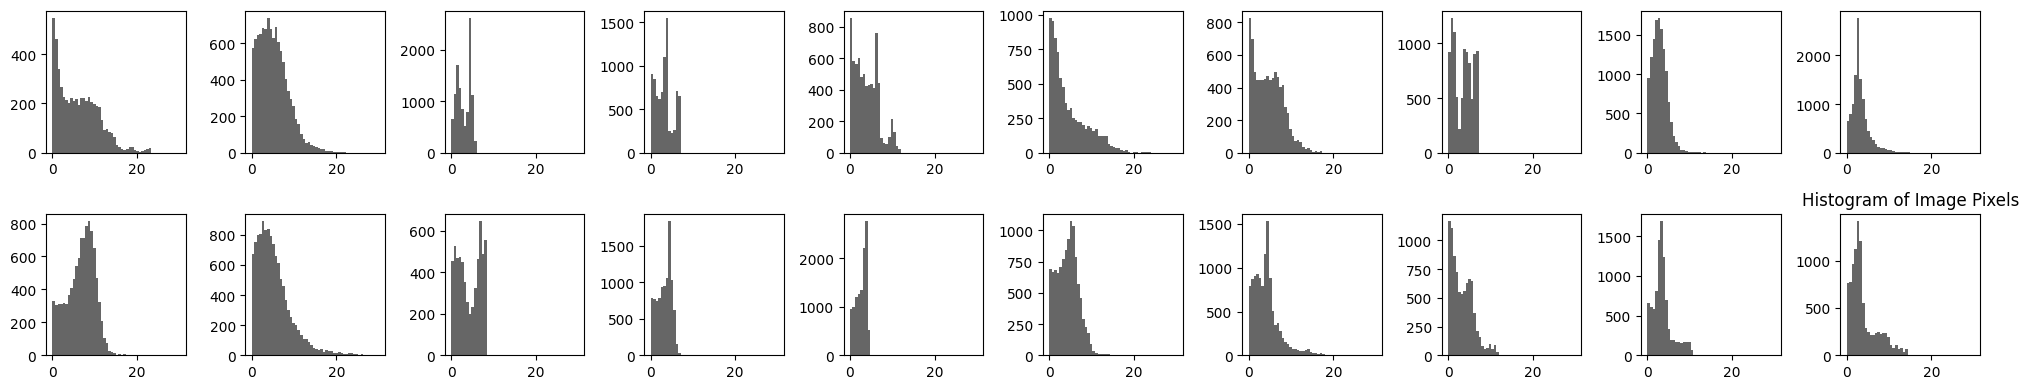

In [ ]:
standardize_images = [standardize_image(image) for image in scaled_images]

plot_histogram_grid(standardize_images, num_samples, range=(0, 30))

## Text Data EDA

For text data (captions), we would like to figure out a few facts:

* Vocabulary size of the corpus

* Caption length

* Simple frequency analysis

In [5]:
def read_captions(file_path: str) -> pd.DataFrame:
    """
    Read the captions from the given file and return them in a DataFrame.

    Parameters
    ----------
    file_path : str
        The path of the file containing the captions.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the captions. The DataFrame has two columns: 'image' and 'caption'.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Each line in the file is in the format 'image#i caption', where 'image' is the image file name,
    # 'i' is the caption number (0-4), and 'caption' is the actual caption
    # We'll split each line into these three parts
    data = {'image': [], 'caption': []}
    for line in lines:
        image, caption = line.strip().split('\t')
        # Remove trailing # from image paths
        image = image.split('#')[0]
        data['image'].append(image)
        data['caption'].append(caption)

    return pd.DataFrame(data)

In [8]:
caption_df = read_captions('/content/data/Flickr8k.token.txt')
caption_df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40455,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40456,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40457,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40458,997722733_0cb5439472.jpg,A rock climber in a red shirt .


### Vocabulary Size

In [ ]:
def vocab_size(captions: list[str]) -> int:
    """
    Compute the vocabulary size of the given captions.

    Parameters
    ----------
    captions : list[str]
        A list of captions.

    Returns
    -------
    int
        The vocabulary size.
    """
    # Create a vocabulary from the captions
    vectorizer = tf.keras.layers.TextVectorization()
    vectorizer.adapt(captions)

    # Compute the vocabulary size
    return len(vectorizer.get_vocabulary())

In [ ]:
vocab_size(caption_df['caption'].tolist())

8830

### Caption Length

In [ ]:
def compute_caption_lengths(captions: List[str]) -> Tuple[int, int, float]:
    """
    Compute the maximum, minimum, and average length of a list of captions.

    Parameters
    ----------
    captions : List[str]
        The list of captions.

    Returns
    -------
    Tuple[int, int, float]
        A tuple containing the maximum length, minimum length, and average length of the captions.
    """
    # Compute the lengths of the captions (split by single white sapce)
    lengths = [len(caption.split(' ')) for caption in captions]

    # Compute the maximum, minimum, and average length
    max_length = max(lengths)
    min_length = min(lengths)
    avg_length = sum(lengths) / len(lengths)

    return {'max_length': max_length, 'min_length': min_length, 'avg_length': avg_length}

In [ ]:
compute_caption_lengths(caption_df['caption'].tolist())

{'max_length': 38, 'min_length': 1, 'avg_length': 11.782155215027187}

### TF-IDF

In [ ]:
def compute_tfidf_matrix(captions: List[str], max_features: int = 500) -> np.ndarray:
    """
    Compute the TF-IDF matrix for the top words in a list of captions.

    Parameters
    ----------
    captions : List[str]
        The list of captions.
    max_features : int, optional
        The maximum number of features (i.e., words) to consider, ordered by term frequency, by default 500.

    Returns
    -------
    np.ndarray
        The TF-IDF matrix. Each row corresponds to a caption, and each column corresponds to a word.
        The value at a specific row and column is the TF-IDF weight of that word in that caption.
    """
    # Instantiate a TfidfVectorizer
    vectorizer = TfidfVectorizer(max_features=max_features)

    # Fit the TfidfVectorizer to the captions and transform the captions into a TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(captions)

    # Return the TF-IDF matrix as a dense array
    return tfidf_matrix.toarray()

def apply_pca(tfidf_matrix: np.ndarray, n_components: int = 500):
    """
    Apply PCA to a TF-IDF matrix and plot the scree plot.

    Parameters
    ----------
    tfidf_matrix : np.ndarray
        The TF-IDF matrix. Each row corresponds to a caption, and each column corresponds to a word.
        The value at a specific row and column is the TF-IDF weight of that word in that caption.
    n_components : int, optional
        The number of components to keep, by default 500.
    """
    # Apply PCA to the TF-IDF matrix
    pca = PCA(n_components=n_components)
    pca.fit(tfidf_matrix)

    # Plot the explained variance ratio
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), 'o-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')
    plt.grid(True)
    plt.show()

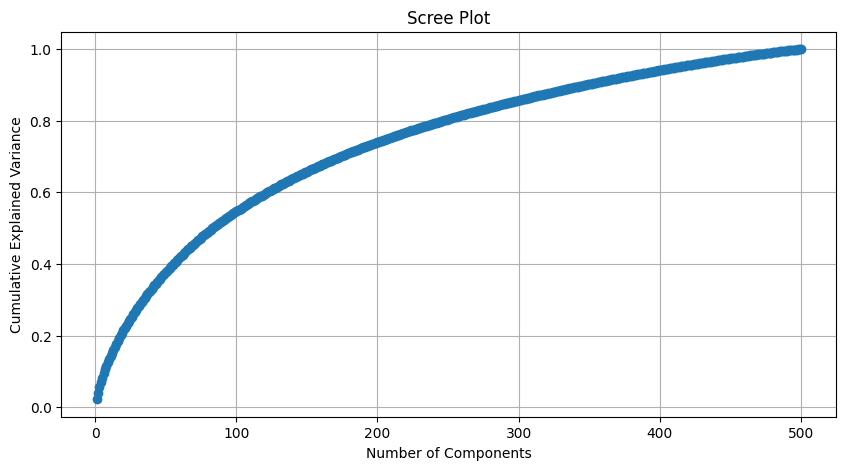

In [ ]:
tfidf = compute_tfidf_matrix(caption_df['caption'].tolist())

apply_pca(tfidf)

### Topic Modeling

In [9]:
def perform_lda(captions: List[str], n_topics: int = 10, max_features: int = 500):
    """
    Perform LDA topic modeling on a list of captions and visualize the top words for each topic.

    Parameters
    ----------
    captions : List[str]
        The list of captions.
    n_topics : int, optional
        The number of topics to extract, by default 10.
    max_features : int, optional
        The maximum number of features (i.e., words) to consider, ordered by term frequency, by default 500.
    """
    # Instantiate a CountVectorizer
    vectorizer = CountVectorizer(max_features=max_features, stop_words='english')

    # Fit the CountVectorizer to the captions and transform the captions into a document-term matrix
    dtm = vectorizer.fit_transform(captions)

    # Perform LDA on the document-term matrix
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda_model.fit(dtm)

    # Get the words in the vocabulary
    words = vectorizer.get_feature_names_out()

    # Visualize the top words for each topic
    for i, topic in enumerate(lda_model.components_):
        print(f"Top words for topic #{i + 1}")
        # Return the indices that would sort an array
        top_words_indices = topic.argsort()[-10:]
        top_words = [words[i] for i in top_words_indices]
        print(top_words)

        plt.figure(figsize=(10, 5))
        plt.bar(top_words, topic[top_words_indices])
        plt.title(f"Top words for topic #{i + 1}")
        plt.show()

Top words for topic #1
['red', 'slide', 'dress', 'walks', 'plays', 'pink', 'young', 'little', 'boy', 'girl']


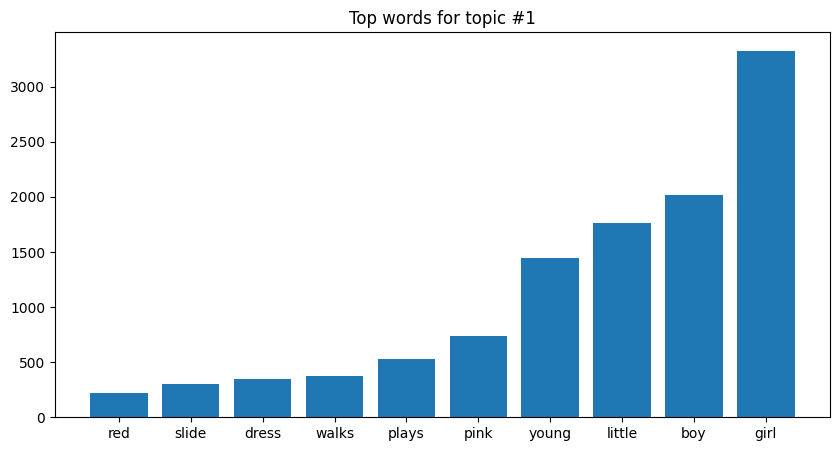

Top words for topic #2
['building', 'red', 'wearing', 'climbing', 'wall', 'sitting', 'dressed', 'rock', 'man', 'standing']


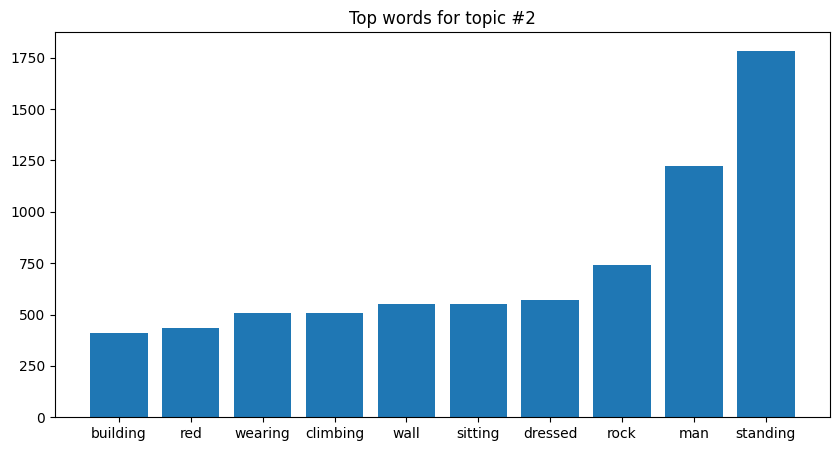

Top words for topic #3
['sit', 'snowy', 'crowd', 'stand', 'men', 'women', 'walking', 'street', 'group', 'people']


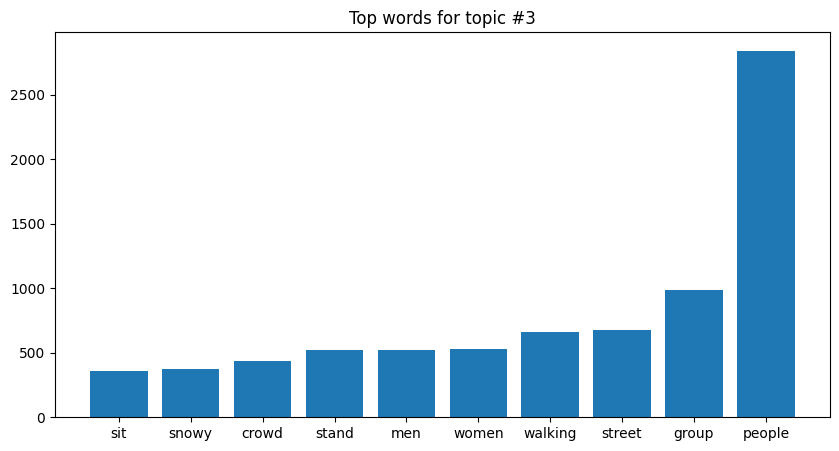

Top words for topic #4
['frisbee', 'red', 'black', 'swimming', 'white', 'air', 'pool', 'jumps', 'dog', 'jumping']


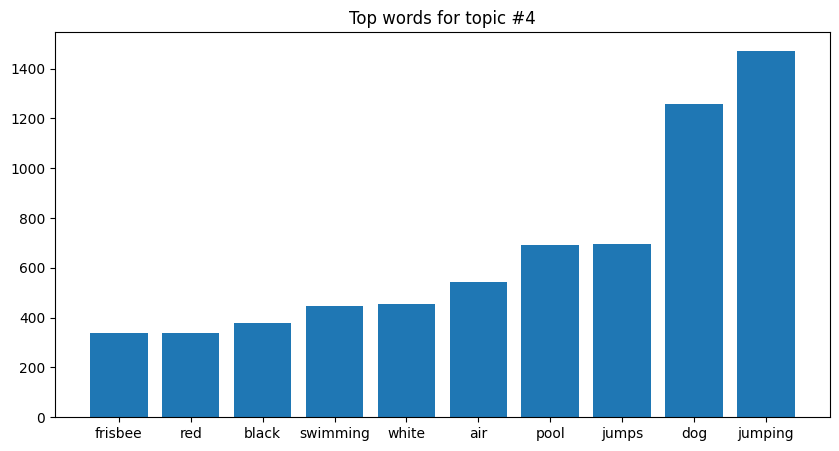

Top words for topic #5
['beach', 'mouth', 'runs', 'water', 'grass', 'running', 'white', 'brown', 'black', 'dog']


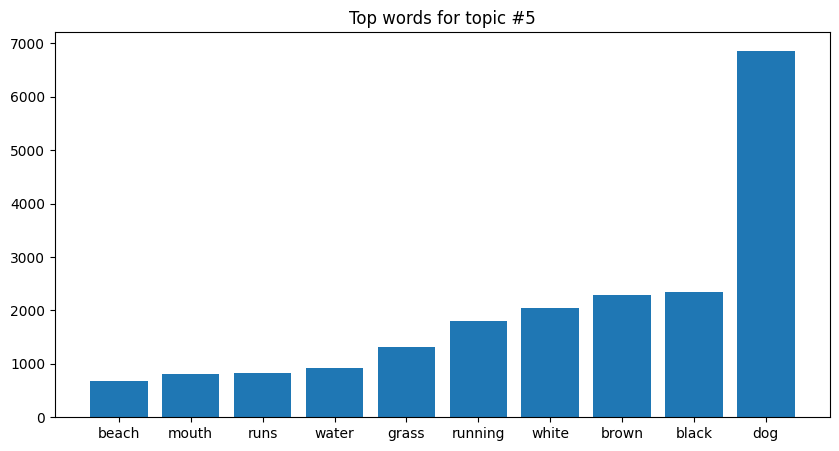

Top words for topic #6
['camera', 'picture', 'small', 'holding', 'sitting', 'park', 'girls', 'woman', 'child', 'man']


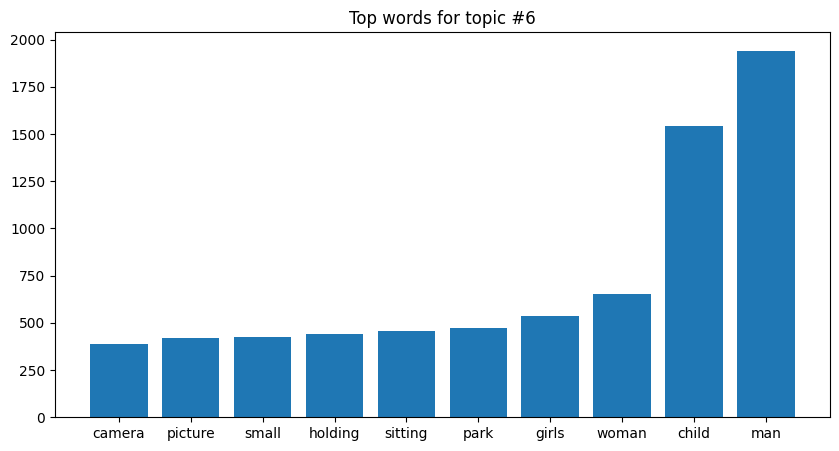

Top words for topic #7
['water', 'soccer', 'race', 'white', 'car', 'tennis', 'red', 'blue', 'player', 'ball']


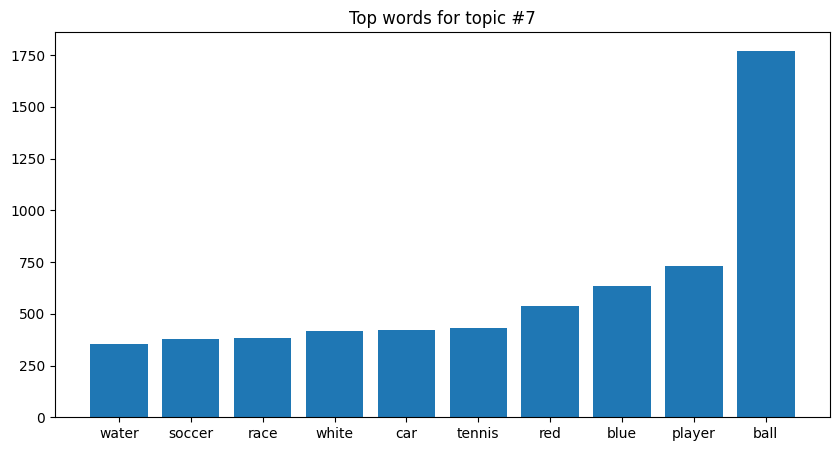

Top words for topic #8
['water', 'kids', 'run', 'snow', 'boys', 'play', 'field', 'children', 'playing', 'dogs']


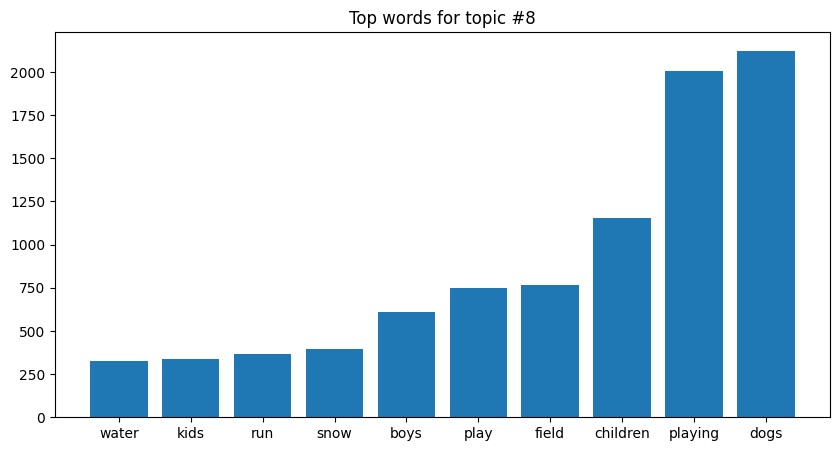

Top words for topic #9
['bicycle', 'doing', 'skateboard', 'dirt', 'rides', 'water', 'bike', 'riding', 'man', 'person']


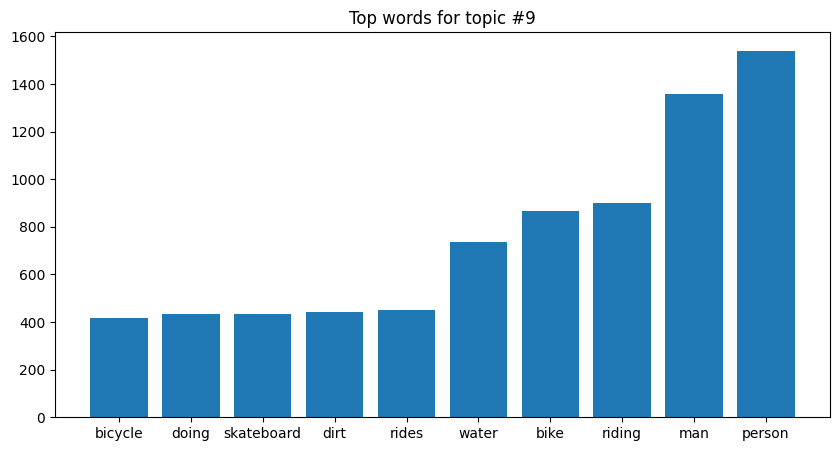

Top words for topic #10
['hat', 'white', 'black', 'red', 'boy', 'blue', 'shirt', 'wearing', 'woman', 'man']


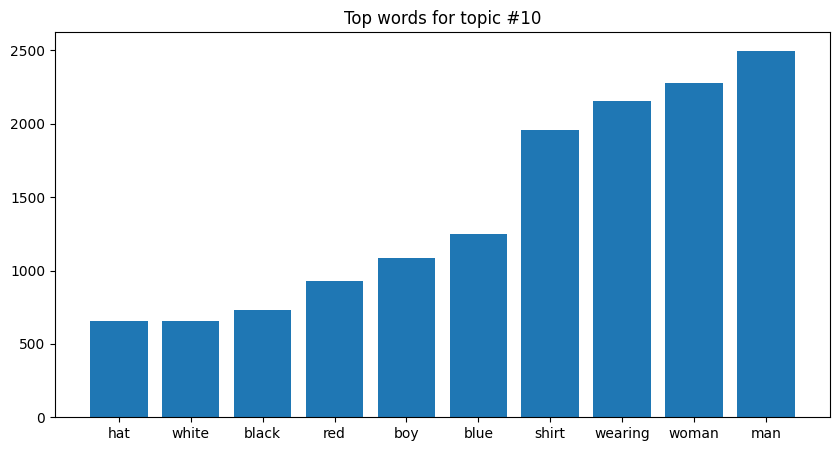

In [10]:
perform_lda(caption_df['caption'].tolist())